In [16]:
# Imports to read the blocks of the Memory Dump/Imports para leer los bloques del Memory Dump
import os
import serial
from datetime import datetime

# Imports to graph the obtained information/Imports para graficar la información obtenida
import matplotlib.pyplot as plt
import pandas as pd
import re as re

In [17]:
# Connection Information of the Hunter Cat/Información de Conexión al Hunter Cat
SERIAL_PORT = 'COM7'  
BAUD_RATE = 9600

Listening on serial port...
Card detected. Saving data to card_20250227_092307.txt
Block 0: 0xD2 0x91 0x10 0x5B 0x06 0x00 0x13 0x1A
Block 1: 0x31 0x17 0x1A 0x31 0x00 0x00 0x00 0x00
Block 2: 0x00 0x00 0x00 0x00 0x00 0x00 0x00 0x00
Block 3: 0xE4 0x12 0x09 0x05 0x81 0x05 0xC8 0xBC
Block 4: 0x99 0x00 0x72 0x05 0xC8 0xD8 0x99 0x00
Block 5: 0x65 0x05 0xC8 0xFC 0x59 0x00 0x3A 0x05
Error reading block: 6 with error: 2
Card detected. Saving data to card_20250227_092318.txt
Block 0: 0xD2 0x91 0x10 0x5B 0x06 0x00 0x13 0x1A
Block 1: 0x31 0x17 0x1A 0x31 0x00 0x00 0x00 0x00
Block 2: 0x00 0x00 0x00 0x00 0x00 0x00 0x00 0x00
Block 3: 0xE4 0x12 0x09 0x05 0x81 0x05 0xC8 0xBC
Block 4: 0x99 0x00 0x72 0x05 0xC8 0xD8 0x99 0x00
Block 5: 0x65 0x05 0xC8 0xFC 0x59 0x00 0x3A 0x05
Block 6: 0xC8 0xD0 0x5A 0x00 0x25 0x05 0xC8 0x20
Block 7: 0x5B 0x00 0xF4 0x04 0xC8 0x4C 0x5B 0x00
Block 8: 0xCE 0x04 0xC8 0x60 0x5B 0x00 0xA2 0x04
Block 9: 0xC8 0x68 0x5C 0x00 0x7F 0x04 0xC8 0x34
Block 10: 0x5D 0x00 0xB9 0x05 0xC8 0xE8 0

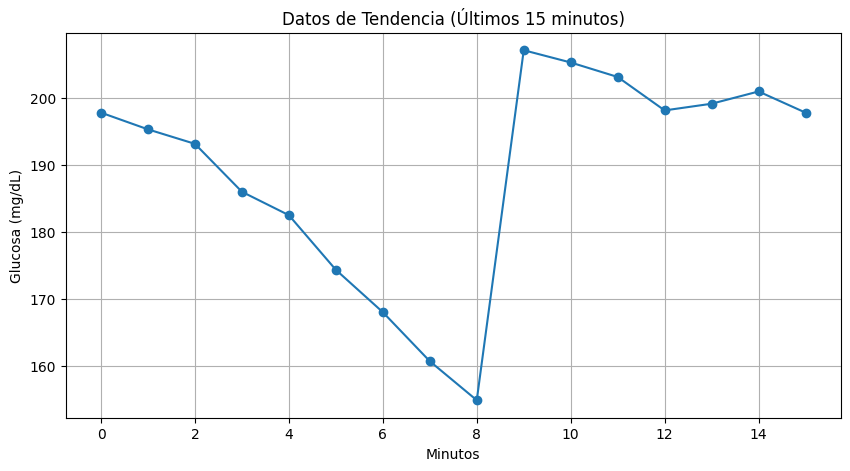

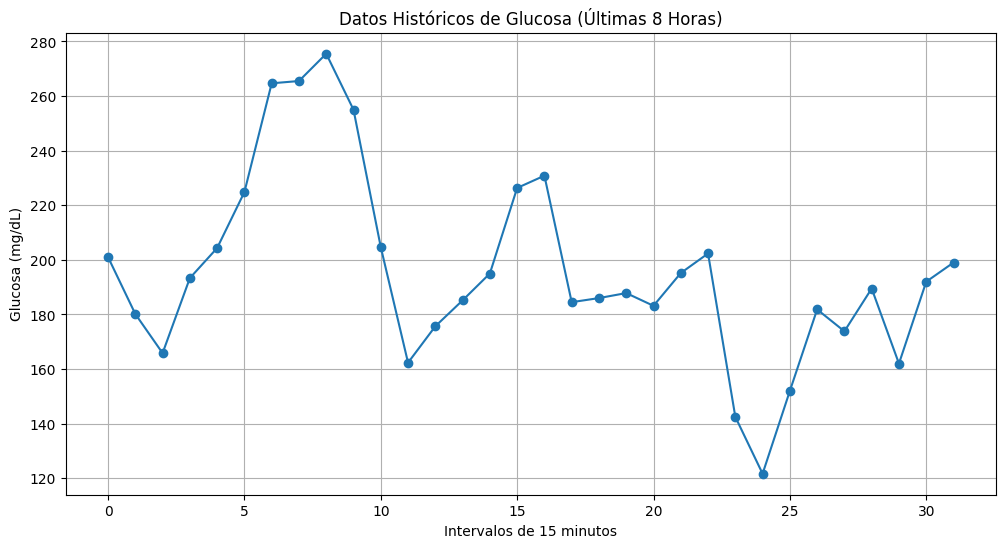

Datos de Tendencia (Últimos 15 minutos):
    Minute     Glucose
0        0  197.833333
1        1  195.333333
2        2  193.166667
3        3  186.000000
4        4  182.500000
5        5  174.333333
6        6  168.000000
7        7  160.666667
8        8  154.833333
9        9  207.166667
10      10  205.333333
11      11  203.166667
12      12  198.166667
13      13  199.166667
14      14  201.000000
15      15  197.833333

Datos Históricos de Glucosa (Últimas 8 Horas)
    Interval (15 min)     Glucose
0                   0  201.000000
1                   1  180.166667
2                   2  165.833333
3                   3  193.333333
4                   4  204.333333
5                   5  224.833333
6                   6  264.666667
7                   7  265.500000
8                   8  275.500000
9                   9  255.000000
10                 10  204.666667
11                 11  162.333333
12                 12  175.666667
13                 13  185.166667
14         

In [18]:
# Creating the variable of the filename of the Memory Dump/Variable para el Archivo de Memory Dump
filename = ""
contador = 0

# Serial Port Connection/Conexión a Serial Port
with serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=1) as ser:
    print("Listening on serial port...")
    while contador < 244:
        line = ser.readline().decode('utf-8').strip()
        if line == "Reading all blocks...":
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f'card_{timestamp}.txt'
            print(f"Card detected. Saving data to {filename}")
            with open(filename, 'w') as f:
                f.write(line + '\n')
                contador = 0
                while contador < 244:
                    line = ser.readline().decode('utf-8').strip()
                    print(line)
                    f.write(line + '\n')
                    if line.lower().startswith("error"):
                        break
                    # if line == "--- End of Card ---":
                    #     break
                    contador+=1
            if (contador < 244):
                    os.remove(filename)


print("Fin de la ejecución del glucometro virtual. ")

# Memory Dump Interpretation and Display of Information/Interpretación del Memory Dump y Despliegue de Información Significativa
# Reading of Memory Dump File/Lectura del Archivo de Memory Dump
def parse_freestyle_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    data = {}
    for line in lines:
        match = re.match(r"Block (\d+): (.+)", line)
        if match:
            block_num = int(match.group(1))
            block_data = match.group(2).split()
            data[block_num] = block_data
    return data

# Function to obtain the glucose information/Function para obtener la información de glucosa
def extract_glucose_values(data):
    def glucoseReading(val):
        bitmask = 0x0FFF
        return ((val & bitmask) / 6) - 37

    # Trends/Tendencias (block 3 byte 4 -> block 15 byte 3)
    trend_raw_bytes = []
    for i in range(3, 16):
        trend_raw_bytes.extend(data[i])

    trend_data = trend_raw_bytes[4:4 + 16*6]  # empieza en el 4 byte
    # print(len(trend_data))
    # print(trend_data)

    # Historic Data/Datos históricos (block 15 byte 4 -> block 39 byte 3)
    history_raw_bytes = []
    for i in range(15, 40):
        history_raw_bytes.extend(data[i])

    history_data = history_raw_bytes[4:4 + 32*6]  # empieza en el 4 byte
    # print(len(history_data))
    # print(history_data)

    # Extraction of glucose information from the 6 bytes packages/Extraemos la información de los paquetes de 6 bytes 
    def parse_records(records):
        glucose_values = []
        for i in range(0, len(records), 6):
            # Remove '0x' prefix before concatenating
            byte1 = records[i+1].replace('0x', '')
            byte0 = records[i].replace('0x', '')
            val = int(byte1 + byte0, 16)
            glucose_values.append(glucoseReading(val))
        return glucose_values

    trend_glucose = parse_records(trend_data[:16*6])
    history_glucose = parse_records(history_data[:32*6])
    # print(trend_data[:16*6])
    # print(history_data[:32*6])

    return trend_glucose, history_glucose

# Obtaining all the Data/Obtención de información 
data = parse_freestyle_file(filename)
trend_glucose, history_glucose = extract_glucose_values(data)

# Creation of structures for the information/Ordenando la informacion para desplegar
trend_df = pd.DataFrame({"Minute": range(0, 16), "Glucose": trend_glucose})
history_df = pd.DataFrame({"Interval (15 min)": range(0, 32), "Glucose": history_glucose})

# Graph 1/Gráfica 1
plt.figure(figsize=(10, 5))
plt.plot(trend_df["Minute"], trend_df["Glucose"], marker='o')
plt.title("Datos de Tendencia (Últimos 15 minutos)")
plt.xlabel("Minutos")
plt.ylabel("Glucosa (mg/dL)")
plt.grid(True)
plt.show()

# Graph 2/Gráfica 2
plt.figure(figsize=(12, 6))
plt.plot(history_df["Interval (15 min)"], history_df["Glucose"], marker='o')
plt.title("Datos Históricos de Glucosa (Últimas 8 Horas)")
plt.xlabel("Intervalos de 15 minutos")
plt.ylabel("Glucosa (mg/dL)")
plt.grid(True)
plt.show()

# Tables/Modo tabular
print("Datos de Tendencia (Últimos 15 minutos):")
print(trend_df)
print("\nDatos Históricos de Glucosa (Últimas 8 Horas)")
print(history_df)